

<center><table>
<tr>

<th> <img src= "INL1.png",align="middle",style="width: 10000px;"/> </th>
</tr>
<tr>
<th> <img src="PennNucDataCenter.jpeg"  ,align="middle", style="width: 500px;"/> </th>
</tr>
<center><table>

# <center>Nuclear-Powered Data Centers Economic Optimization Strategy</center>

#### Expected Outcome
- A journal paper evaluating <u>the economic threshold points</u> identifying the conditions under which user requirements would be better suited by a large, small, or micro-reactor. The use case will be focused on data centers and will provide INL with the credential to stake a claim as a leader in nuclear for data center research.

- With a framework on hand, the lab could then leverage its expertise to offer advisory support for the various data centers considering nuclear energy. Further, with interest growing in this area, it is possible that DOE-NE would sponsor research on coupling nuclear reactors with data centers. INL would be well positioned to lead such R&D activities.

#### Activity
- A framework is proposed to evaluate the **economic tradeoff** between large, small, and micro-reactors. 
- The intent is to map out ‘threshold values’ under a given set of requirements 
  - energy demand size
  - reliability 
  
- The framework would parametrize a set of important economic variables to quantifiably differentiate the different reactor classes. 
  - nuclear capacity
  - diseconomies of scale, 
   - economies of mass production, 
   - speed of deployment, 
   - downtime intervals  



### Required Imports

In [1]:
#!/usr/local/bin/python3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src import *

## The schedule for one reactor

In [ ]:
fig = plt.figure(figsize=(10, 3))
power = 10 # MWe
fuel_lifetime = int(np.ceil((2*365)/7))# weeks
refueling_period = 4 # 4 weeks
levelization_period = int((30*365)/7) # weeks
inital_delay = 0


t_list = []
P_list = []
for time in range(1, levelization_period+1):
    P = calculate_duty_cycle_weeks_approach( inital_delay, fuel_lifetime, refueling_period, levelization_period, power, time)
    t_list.append(time)
    P_list.append(P)



plt.plot((np.array(t_list))/52.1429, P_list)
plt.xlim(0, 6)
plt.ylim(0, 1.05*power)
plt.xlabel('Time (years)', fontsize=18) 
plt.ylabel('Power', fontsize=18) 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)


# plt.title(f"Refueling schedule for a Single Reactor \n Fuel Lifetime = {int(np.round(fuel_lifetime/52.1429, 1))} Years, \
# Refueling Duration = {refueling_period} Weeks  \n",  fontsize=18)

plt.savefig(f'schedule.png', bbox_inches='tight')

# plt.show()

## The schedule for 2 reactors
The second reactor should start after the first reactor with a delay equals 1 refueling period. This way we guarantee that:
1. Both reactors will never be off at the same time, 
2- Use the full power of the two reactors ASAP


In [ ]:
fig = plt.figure(figsize=(10, 3))

inital_delay1 = 0
inital_delay2 = refueling_period 

t_list = []
P_list1 = []
P_list2 = []
for time in range(1, levelization_period+1):
    P1 = calculate_duty_cycle_weeks_approach( inital_delay1, fuel_lifetime, refueling_period, levelization_period, power, time)
    t_list.append(time)
    P_list1.append(P1)
    P2 = calculate_duty_cycle_weeks_approach( inital_delay2, fuel_lifetime, refueling_period, levelization_period, 1.1*power, time) # I change the power her for visualization
    if P2 == 0:
        if P1 ==0:
            print("WARNING: P2 = 0 and P1 =0")
    P_list2.append(P2)



plt.plot( np.array(t_list)/52.1429 , P_list1, label = "reactor #1")
plt.plot(np.array(t_list)/52.1429 , P_list2, label = "reactor #2")
# plt.legend( loc='lower right' , fontsize=17)
plt.xlim(0, 6)

plt.xlabel('Time (years)', fontsize=18) 
plt.ylabel('Power', fontsize=18) 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

plt.gca().yaxis.set_major_locator(plt.NullLocator())

# plt.title(f"Refueling Schedule for two reactors \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years\
# , Refueling Period = {refueling_period} days  \n", fontsize=16)

plt.savefig(f'schedule_2.png', bbox_inches='tight')

plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  \le \frac{fuel \, Lifetime}{Refueling \, Period} $



In [ ]:
fig = plt.figure(figsize=(10, 3))

num_reactors = 4

initial_delay_list =list(refueling_period*np.linspace(0,  num_reactors-1, num_reactors) )
P_list_tot = []
for i in range(len(initial_delay_list)):
    
    delay = initial_delay_list[i] 
    P = power *(1+ i *0.05) # just for visualization
    
    t_list = []
    P_list = []

    for time in range(1, levelization_period+1):
       
        P = calculate_duty_cycle_weeks_approach( int( delay), fuel_lifetime, refueling_period, levelization_period, power, time)
      
        t_list.append(time)
        P_list.append(P)

    P_list_tot.append(P_list)

    plt.plot(np.array(t_list)/52.1429, P_list, label = f"reactor # {i+1}")
    # plt.legend( loc='lower right' , fontsize=15)
    plt.xlim(0, 6)

    plt.xlabel('Time (years)', fontsize= 18) 
    plt.ylabel('Power', fontsize=18) 

#     plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years ,\
#     Refueling Period = {refueling_period} days  \n", fontsize=16)
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f'schedule_4.png', bbox_inches='tight')

plt.show()

print( "startup period  = ", initial_delay_list[-1], "weeks")

In [ ]:
fig = plt.figure(figsize=(10, 4))

P_list_tot_array = (np.vstack(P_list_tot))
reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))

plt.plot(np.array(t_list)/52.1429,  reactors_down_list) 
plt.xlabel('Time (years)', fontsize= 18) 
plt.ylabel('# of reactors offline?', fontsize= 18) 
plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Operational Lifetime = {int(fuel_lifetime/52.1429)} years\n Refueling Duration = {refueling_period} weeks ", fontsize= 17,\
    x=0.7, y=0.7, backgroundcolor='white') 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.xlim(0, 12)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  > \frac{fuel \, Lifetime}{Refueling \, Period} $

An example for visualization (not realistic):
- fuel lifetime = 4 months
- refueling period = 1 months
- number of reactors = 7

Since the total number of refueling  = 1 months * 7 reactors = 7 months which is longer than the fuel lifetime which is 4 months, this means that more than one reactor has to be down at sometime

Using increments of 1 months (the refueling period), all the reactors have to be refueled within one cycle.
The number of reactos to be refueled at the same time $= \frac{7}{4}  = 1\frac{3}{4} $

-Therefore, 2 reactors will be refueled each month (in the first 3 months) and 1 reactor is refueled in the 4th month

<br>


This can be formulated as follows
- $number \, of\, reactors \, down \, at \, one\,  refueling\, period \in  [ Ceiling[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}] \, , \, Floor[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}]] $

    - The number of refueling period where the ceiling value is taken is :  $ \frac {modulus(num \, of \, reactors \, \times \, refueling \, period \, , \, refueling \, period) }{refueling \, period}$

# General Example (should work for any variables)

In [ ]:
fig = plt.figure(figsize=(12, 6))

num_reactors = 4
power1 = 1

schedule = calculate_schedule_multiple_reactors_weeks_approach(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period) 
times =  schedule[0]
powers =  schedule[1]

# for n in range(len(powers)): # i can plot this but it is hard to see!
#     plt.plot(times, powers[n] )


P_list_tot_array = (np.vstack(powers))

reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))


plt.plot(np.array(times)/52.1428,  reactors_down_list) 
plt.xlabel('Time (years)', fontsize=16)
plt.ylabel('How many reactors are down per day?', fontsize=16)
# plt.title(f"Refueling Schedule for {num_reactors} reactors \n Fuel Lifetime = { int(np.round(fuel_lifetime/365, 1))} years , Refueling Period = {refueling_period} days  \n", fontsize=16)


plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.xlim(0, 12)
# plt.ylim(0, 3.1)
print( "ramp up to full power period  = ", schedule[2], "weeks")

plt.savefig(f'Num_reactors_Down_4.png', bbox_inches='tight')





In [ ]:
fig = plt.figure(figsize=(10, 4))
num_reactors = 200
schedule = calculate_schedule_multiple_reactors_weeks_approach(fuel_lifetime, refueling_period, num_reactors, power1, levelization_period) 
times =  schedule[0]
powers =  schedule[1]

# Here we assume a microreactor
fuel_lifetime = operational_lifetime_estimate(20)
refueling_period = refueling_period_estimate(20)


P_list_tot_array = (np.vstack(powers))

reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))


plt.plot(np.array(times)/52.1428,  reactors_down_list) 
# plt.yscale('log')

plt.xlabel('Time (years)', fontsize=18)
plt.ylabel('# of reactors offline', fontsize=18)

plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Operational Lifetime = {np.ceil(fuel_lifetime/52.1429)} years\n Refueling Duration = {refueling_period} weeks ", fontsize= 17,\
    x=0.69, y=0.7, backgroundcolor='white') 


plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

plt.minorticks_on()
plt.xlim(0, 13) # 
plt.ylim(0, num_reactors)

print( "ramp up to full power period  = ", schedule[2], "weeks")
plt.show()
plt.savefig(f'Num_reactors_Down_1000.png', bbox_inches='tight')

# Capacity factor (An example: 1 MW microreactor, 1000 reactors)

In [ ]:
fig = plt.figure(figsize=(14, 4))


# Here we assume a microreactor
fuel_lifetime = operational_lifetime_estimate(20)
refueling_period = refueling_period_estimate(20)


# # remove the data before getting to the full power
times_array =np.reshape(np.array(times) , (1, len(times)))
times_power_array = np.concatenate((times_array , P_list_tot_array)) # merging the time and power in one array
times_power_array_excludingRampUp = times_power_array[:,int(schedule[2]):] # remove the initial rampup period

#extract time and power after excluding the initial ramp up period
times_array_excludingRampUp = times_power_array_excludingRampUp[0]
power_array_excludingRampUp = np.delete(times_power_array_excludingRampUp, (0), axis=0)


# nominal power and actual power
tot_nom_output_t    = power1*num_reactors # total nominal power (assuming 100% availability) at each timestep (at each day)
tot_actual_output_t =  sum(power_array_excludingRampUp)
capacity_factor_t = tot_actual_output_t/tot_nom_output_t 
plt.plot(times_array_excludingRampUp/52.1428571429, capacity_factor_t )



tot_nom_output = tot_nom_output_t * (len(times_array_excludingRampUp)) # total power per day of all reactors multiplied by the number of days
tot_actual_output_t = sum(tot_actual_output_t)
overall_capacity_factor = tot_actual_output_t/tot_nom_output


plt.xlabel('Time (years)', fontsize=18)
plt.ylabel('Daily Aggregate Capacity Factor', fontsize=16)
plt.title(f"Trend of the Daily Aggregate Capacity Factor over time \n Operational Lifetime = { int(np.round(fuel_lifetime/52.1428571429, 1))} years, \
Refueling Duration = {refueling_period} weeks, \n\
    Levelization Period = {np.round(levelization_period/52.1428571429, 1)} years, number of reactors = {num_reactors},\n Lifetime Aaggregate Capacity Factor = {np.round(overall_capacity_factor,5)} \n ", fontsize=18)

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.xlim(0, levelization_period/52.1428571429)
plt.ylim(0.99, 1.001)

plt.savefig(f'capacity_factor_1000.png', bbox_inches='tight')

plt.show()




# print(f"Capacity Factor over the plant lifetime is : {overall_capacity_factor }")
#



# Daily Aggregate Capacity Factor  & Lifetime Aggregate Capacity Factor Criteria

In [ ]:
# number of reactors to achieve the target demand 

levelization_period = int(np.ceil(30*365/7))


demand_0 = 1000 # MWe
power_list = [1000, 500, 300, 200, 100  ,50, 20, 5, 1]
capacity_factor_criteria_list = [0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]
num_reactors_save_tot = []

for power in power_list :
    num_reactors_save = []
    num_reactors_current = 0 # initialization
    
    fuel_lifetime = operational_lifetime_estimate(power)
    refueling_period = refueling_period_estimate(power)
    
    for capacity_factor_criteria in capacity_factor_criteria_list :
    
        num_reactors_0 =  max( int( np.ceil( demand_0 /power)), num_reactors_current)
        
        for  num_reactors in np.linspace( num_reactors_0 , 2*num_reactors_0, 1+num_reactors_0):
            
                
            times_array_excludingRampUp = (capacity_factor_weeks_approach(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
            # capacity_factor_min =        min ((capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
            overall_capacity_factor   =   (capacity_factor_weeks_approach(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[2]
            
            
            
            if  overall_capacity_factor>=  capacity_factor_criteria:
                print(   f" {num_reactors } {power} (MW) reactors : The lifetime capacity factor is { overall_capacity_factor} ")
                num_reactors_save.append(num_reactors)
                num_reactors_current = int(num_reactors)
                
                break
    
            
    num_reactors_save_tot.append(num_reactors_save)        

In [ ]:


fig = plt.figure(figsize=(10, 6))


for i in range(len(num_reactors_save_tot) - 3):
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, label =f'P = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.ylim(0, 22)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Required number of reactors',  fontsize=14)


plt.grid(which='major', color='grey', linewidth=0.8)
# plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()




fig = plt.figure(figsize=(10, 6))


for i in range(5, len(num_reactors_save_tot) -2):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'b',label =f'P = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# plt.ylim(0, 12)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))




plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
# plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()

fig = plt.figure(figsize=(10, 6))
for i in range(6, len(num_reactors_save_tot) -1):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'y',label =f'P = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

# 
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()





fig = plt.figure(figsize=(10, 6))
for i in range(7, len(num_reactors_save_tot) ):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = 'k',label =f'P = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)



plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()



plt.show()

# Minimum Capacity Factor

In [ ]:
# number of reactors to achieve the target demand 
levelization_period = int(np.ceil(30*365/7))

demand_0 = 1000 # MWe
power_list = [1000, 500, 300, 200, 100  ,50, 20, 5, 1]
min_capacity_factor_criteria_list = [0.9, 0.92  , 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]

n_reactors_save_tot = []
for power in power_list :
    n_reactors_save = []
    n_reactors_current = 0 # initialization
    
    fuel_lifetime = operational_lifetime_estimate(power)
    refueling_period = refueling_period_estimate(power)
    
    for min_capacity_factor_criteria in min_capacity_factor_criteria_list :
    
        n_reactors_0 =  max( int( np.ceil( demand_0 /power)), n_reactors_current)
        for  num_reactors in np.linspace( n_reactors_0 , 2*n_reactors_0, 1+n_reactors_0):
            
                
            times_array_excludingRampUp = (capacity_factor_weeks_approach(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
            capacity_factor_min =        min ((capacity_factor_weeks_approach(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
            print( power, num_reactors, min_capacity_factor_criteria, capacity_factor_min  )
            if  capacity_factor_min >=  min_capacity_factor_criteria:
                n_reactors_save.append(num_reactors)
                n_reactors_current = int(num_reactors)
                
                break
    
            
    n_reactors_save_tot.append(n_reactors_save) 

In [ ]:
fig = plt.figure(figsize=(12, 6))



for i in range(len(num_reactors_save_tot) - 3):
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = color_of(power_list[i]) ,alpha=0.5, label =f'{power_list[i]} $MW_e$ (Lifetime Capacity Factor)')
    plt.plot(min_capacity_factor_criteria_list, n_reactors_save_tot[i],linestyle = 'dashed', color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Daily Capacity Factor)')
    plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', fontsize=18 )

plt.ylim(0, 22)


plt.xlabel('Target Aggregate Capacity Factor',  fontsize=18 )
plt.ylabel('Req. Num of Reactors',  fontsize=18)

plt.title( f"Demand  = {demand_0} $MW_e$ , Levelization Period = {np.round (levelization_period/52.1428571429, 1) } years \n  ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17) 
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))
plt.savefig(f'num_reactors_to_satisfy_reliability1.png', bbox_inches='tight')

plt.show()




fig = plt.figure(figsize=(5, 3))

for i in range(6, 7):
    
    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = color_of(power_list[i]) ,label =f'{power_list[i]} $MW_e$ (Lifetime Capacity Factor)')
    plt.plot(min_capacity_factor_criteria_list, n_reactors_save_tot[i],linestyle = 'dashed', color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Daily Capacity Factor)')
    plt.legend(bbox_to_anchor=(0.4, 1.5),loc='upper center', fontsize=15 )

# # plt.ylim(0, 12)


plt.ylabel('Req. Num of Reactors',  fontsize=16)
plt.xlabel('Target Aggregate Capacity Factor',  fontsize=16 )

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))


# plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
#      Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)  
plt.savefig(f'num_reactors_to_satisfy_reliability2.png', bbox_inches='tight')

plt.show()



fig = plt.figure(figsize=(5, 3))
for i in range(7, 8):

    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Lifetime Capacity Factor)')
    plt.plot(min_capacity_factor_criteria_list, n_reactors_save_tot[i],linestyle = 'dashed', color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Daily Capacity Factor)')

    plt.legend(bbox_to_anchor=(0.4, 1.5),loc='upper center', fontsize=15 )


plt.xlabel('Target Aggregate Capacity Factor',  fontsize=16 )
plt.ylabel('Req. Num of Reactors',  fontsize=16)

# plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
#      Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)  
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
plt.savefig(f'num_reactors_to_satisfy_reliability3.png', bbox_inches='tight')

plt.show()





fig = plt.figure(figsize=(5, 3))
for i in range(8, 9):

    plt.plot(capacity_factor_criteria_list, num_reactors_save_tot[i], '-o' , markersize = 10, color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Lifetime Capacity Factor)')
    plt.plot(min_capacity_factor_criteria_list, n_reactors_save_tot[i],linestyle = 'dashed',color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Daily Capacity Factor)')
    plt.legend(bbox_to_anchor=(0.4, 1.5),loc='upper center', fontsize=15 )


plt.xlabel('Target Aggregate Capacity Factor',  fontsize=16 )
plt.ylabel('Req. Num of Reactors',  fontsize=16)

# plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {int(np.round(fuel_lifetime/30/12, 1))} years ,   Refueling Period = {refueling_period} days ,\
#      Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)  
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))

plt.savefig(f'num_reactors_to_satisfy_reliability4.png', bbox_inches='tight')

plt.show()



In [ ]:

# fuel_lifetime_0 = 2*12*30 # days
# refueling_period_0 = 30 # days
# levelization_period_0 = 30*365 # days
# demand_0 = 3000

# overall_capacity_factor_criteria = 0.99
# min_capacity_factor_criteria = 0.9

# # ref large reactor
# ref_large_reactor_cost_per_kw = 1 # the cost here does not matter because we calculate ratios
# large_reactor_ref_power = 1000 # This is the average power in the GAIN metanalaysis report (and i rouneded it)
# LR_Large = 0.061 # from PWR (76% cost ratio for the 20th reactor) ... 8% in the GAIN report

# # small reactor

# lr_small_min = 0
# lr_small_max = 0.2
# lr_small_interval = 0.01

# num_LR_small = 1+abs(int(np.ceil( (lr_small_min - lr_small_max)/ lr_small_interval) ) ) 

# min_cost_small = cost_large 
# max_cost_small = 50*cost_large 
# cost_interval_small = 20 # 50 dollars
# num_cost_small = int(np.ceil(1 + abs(max_cost_small  - min_cost_small )/ cost_interval_small  ) )


# # #Step1 : calculate cost of the large ractor
# num_reactors_needed_large = num_reactors_needed_for_capacity_factor(overall_capacity_factor_criteria, min_capacity_factor_criteria, fuel_lifetime_0, refueling_period_0, power_large, levelization_period_0, demand_0)

# final_cost_large = calculate_final_cost_due_to_learning_rate(cost_large , LR_Large, int(num_reactors_needed_large)  )

# final_cost_per_demand_large = final_cost_large * (num_reactors_needed_large*power_large/demand_0)

# power_list = [300, 100 ] # ,50 ,20, 10, 5, 1

# # # Step2: calculate cost of small reactor that matches the large reactor
# lr_small_save_tot = []
# tipping_cost_save_tot = []
# for power_small in power_list:
    
#     num_reactors_needed_small = num_reactors_needed_for_capacity_factor(overall_capacity_factor_criteria, min_capacity_factor_criteria, fuel_lifetime_0, refueling_period_0, power_small, levelization_period_0, demand_0)

#     lr_small_save = []
#     tipping_cost_save = []

#     for lr_small in np.linspace(lr_small_min, lr_small_max , num_LR_small ): 
          
        
#         for cost_small in np.linspace(max_cost_small, min_cost_small, num_cost_small):
        
#             final_cost_small = calculate_final_cost_due_to_learning_rate(cost_small , lr_small, int(num_reactors_needed_small)  )
#             final_cost_per_demand_small = final_cost_small* (num_reactors_needed_small*power_small/demand_0)
#             if final_cost_per_demand_small  <=  final_cost_per_demand_large:
#                 cost_tipping_point = final_cost_per_demand_small
#                 tipping_cost_save.append(cost_small)
#                 lr_small_save.append(lr_small)
#                 print(power_small, "MWe", "LR = ", lr_small)  
#                 break
#     lr_small_save_tot.append(lr_small_save)
#     tipping_cost_save_tot.append( tipping_cost_save)

In [ ]:
# fig = plt.figure(figsize=(16, 10))

# for i in range (len(lr_small_save_tot)):
#     plt.plot(lr_small_save_tot[i], np.array(tipping_cost_save_tot[i])/cost_large ,'-o' , markersize = 10, label =f'Power = {power_list [i]} MWe')
#     plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


# plt.grid(which='major', color='grey', linewidth=0.8)
# plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
# plt.minorticks_on()
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)  

# plt.xlabel('Learning Rate',  fontsize=16 )
# plt.ylabel('Small Reactor to Large Reactor \n FOAK Cost (USD/ MWe) Ratio \n',  fontsize=14)
# plt.xlim(0, 0.2)
# plt.ylim(1, 15)
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.02))

# plt.title(f"Cost Tipping Point: Where the total Cost of an SMR/micro reactor ($/demand in MWe) equals the cost of a large reactor : \n Fuel Lifetime = {np.round(fuel_lifetime_0 /30, 1)} months ,   Refueling Period = {refueling_period_0} days ,\
#      Levelization Period = {np.round(levelization_period_0/365, 1)} years \n Demand  = {demand_0} MWe , Target Capacity Factor (per day) = {min_capacity_factor_criteria} \n"  , fontsize=16)
# plt.show()

# cost tipping points

Demand (MW) =  500
power (MW) =  500
power (MW) =  300
power (MW) =  200
power (MW) =  100
power (MW) =  50
power (MW) =  20
power (MW) =  5
power (MW) =  1


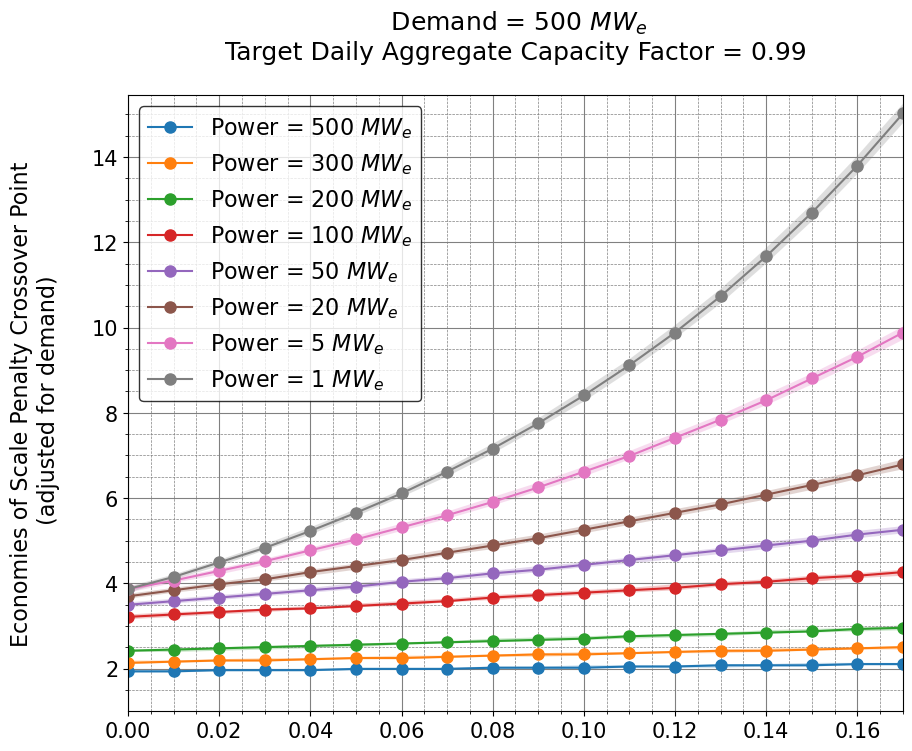

Demand (MW) =  1000
power (MW) =  500
power (MW) =  300
power (MW) =  200
power (MW) =  100
power (MW) =  50
power (MW) =  20
power (MW) =  5
power (MW) =  1


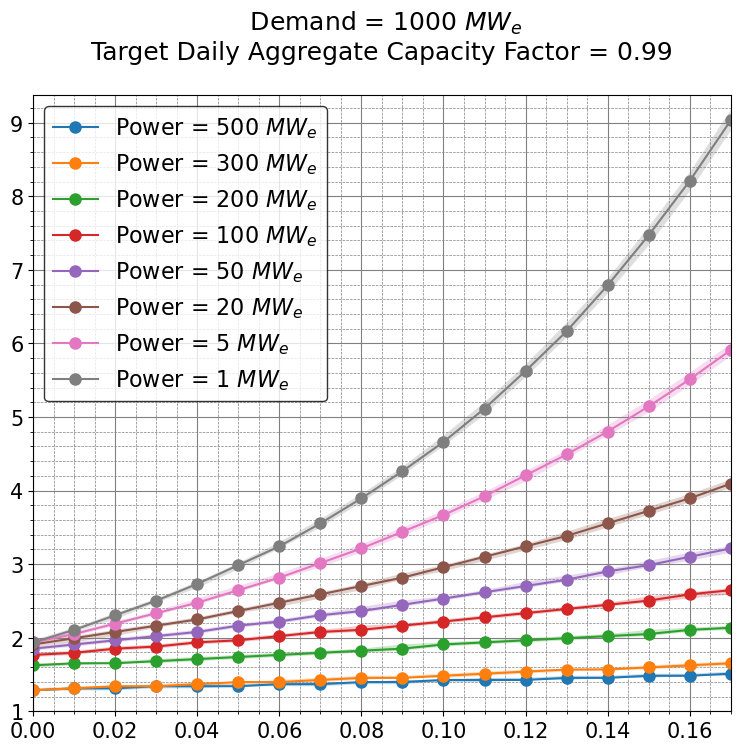

Demand (MW) =  3000
power (MW) =  500
power (MW) =  300
power (MW) =  200
power (MW) =  100
power (MW) =  50
power (MW) =  20
power (MW) =  5
power (MW) =  1


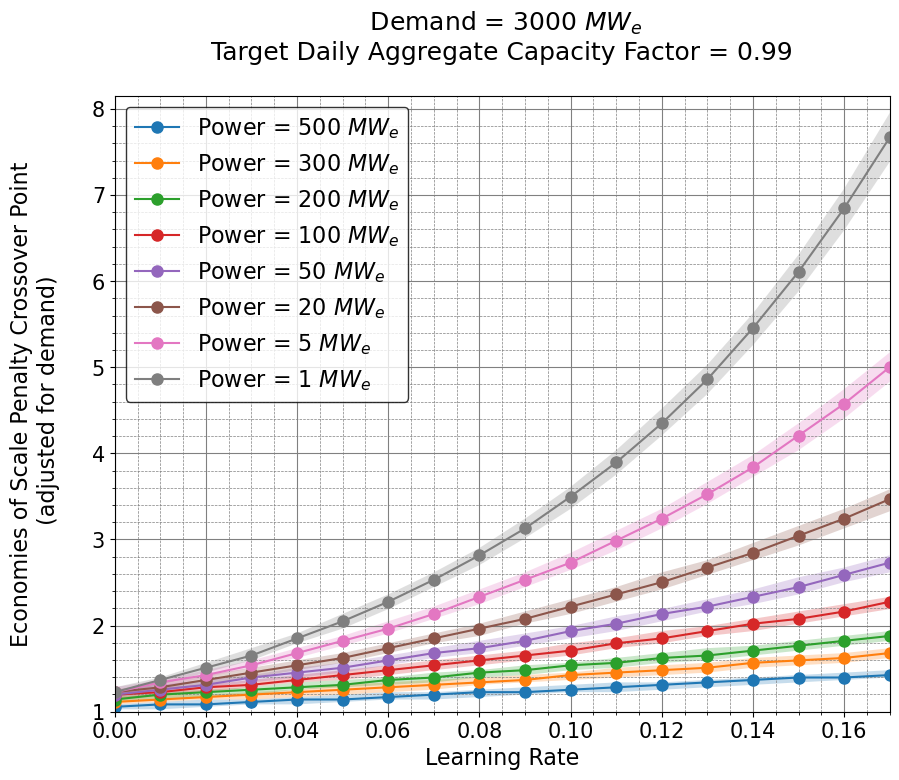

Demand (MW) =  6000
power (MW) =  500
power (MW) =  300
power (MW) =  200
power (MW) =  100
power (MW) =  50
power (MW) =  20
power (MW) =  5
power (MW) =  1


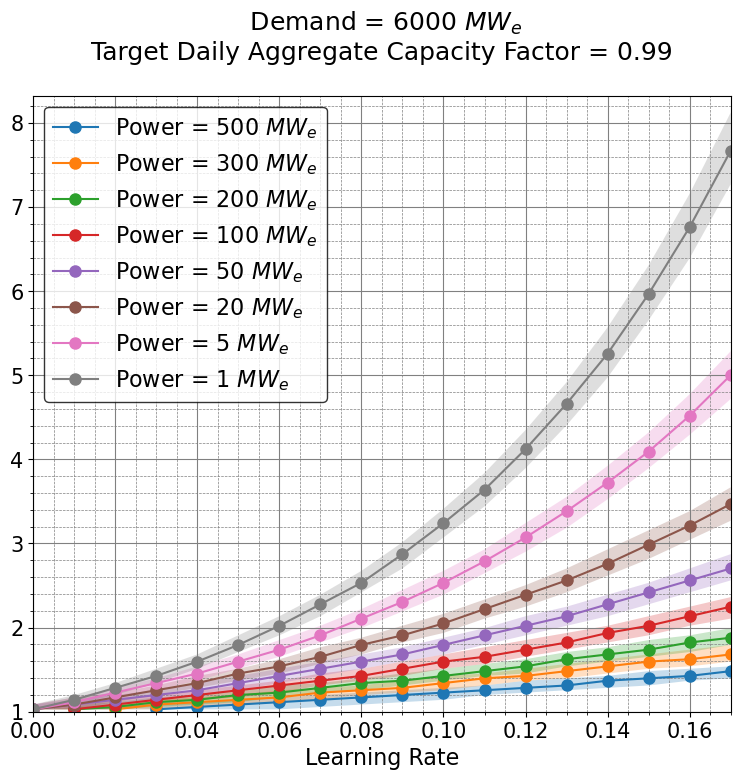

In [2]:
large_lr_avg = 0.08 # AVG L 8% Learning rate
large_lr_std = 0.03 # std = 0.03
large_lr_lo = large_lr_avg - large_lr_std
large_lr_hi = large_lr_avg + large_lr_std
  
levelization_period_0 = int(np.ceil((30*365)/7))# 30 years   

overall_capacity_factor_criteria = 0.9
min_capacity_factor_criteria     = 0.99    
    
large_reactor_ref_power = 1000 # This is the average power in the GAIN metanalaysis report (and i rouneded it)    

lr_min = 0
lr_max = 0.17

pwr_list = [500 ,  300 , 200, 100  ,50, 20,5, 1]
lr_interval = 0.01
num_LR_small = 1+int(np.ceil( (lr_max - lr_min )/ lr_interval) )

ref_large_reactor_cost_per_kw = 1 # the cost here does not matter because we calculate ratios
min_cost_small = ref_large_reactor_cost_per_kw
max_cost_small = 18 *min_cost_small 
num_cost = 600

fuel_lifetime_large     =  operational_lifetime_estimate(large_reactor_ref_power )
refueling_period_large  =   refueling_period_estimate(large_reactor_ref_power ) 
    
for demand in [500, 1000, 3000, 6000]:
    print("Demand (MW) = ", demand)    
    
    if demand == 500 or demand == 3000:
        fig = plt.figure(figsize=(10, 8))
    else: 
        fig = plt.figure(figsize=(9, 8))  

    

    for power in pwr_list:
        print("power (MW) = ", power)
        
        fuel_lifetime_small = operational_lifetime_estimate(power)  # days (3 years for SMR)
        refueling_period_small = refueling_period_estimate(power)

        
        lr_small_list = []
        lr_small_list1 = []
        breakeven_points_0_list = []
        breakeven_points_1_list = []
        avg_point_list = []
        
        num_large_reactors = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                min_capacity_factor_criteria, fuel_lifetime_large, refueling_period_large, large_reactor_ref_power ,\
                    levelization_period_0, demand)))

        num_small_reactors =  int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                min_capacity_factor_criteria, fuel_lifetime_small, refueling_period_small, power ,\
                    levelization_period_0, demand)))
        
        for lr_small in np.linspace(lr_min,lr_max ,num_LR_small) :
        
            try:
                breakeven_points = calculate_break_even_cost_for_lr_per_demand(lr_small, large_lr_lo, large_lr_hi,\
        ref_large_reactor_cost_per_kw, num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small,\
            num_cost, demand, large_reactor_ref_power, power)
                
                
                lr_small_list.append(lr_small)
                breakeven_points_0_list.append(breakeven_points[0])
                breakeven_points_1_list.append(breakeven_points[1])
                
            except:
                ...

            try:
                # For the 8% avg LR for the large reactor
                avg_point = calculate_break_even_cost_for_lr_per_demand(lr_small, large_lr_avg, large_lr_avg,\
        ref_large_reactor_cost_per_kw, num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small,\
            num_cost, demand, large_reactor_ref_power, power)
                
                avg_point_list.append(avg_point[0])
                lr_small_list1.append(lr_small)
            except:
                ...
                
        plt.fill_between(lr_small_list, breakeven_points_0_list , breakeven_points_1_list, alpha=0.25)  
        plt.plot(lr_small_list1, avg_point_list,  '-o' , markersize = 8,label = f"Power = {int(power)} $MW_e$")     

    plt.legend( loc='upper left', fontsize=16, edgecolor='black', fancybox=True)   # bbox_to_anchor=(1.05, 1.0)

    plt.grid(which='major', color='grey', linewidth=0.8)
    plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
    plt.minorticks_on()
    if demand == 6000 or demand == 3000:
        plt.xlabel('Learning Rate', fontsize=16) 
    
    if demand == 500 or demand == 3000:
        plt.ylabel('Economies of Scale Penalty Crossover Point\n (adjusted for demand)\n', fontsize=16)  

    plt.ylim(1, max(breakeven_points_1_list)+0.2 )
    plt.xlim(0, lr_max ) 
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)

    plt.title(f' Demand = {demand} $MW_e$\n Target Daily Aggregate Capacity Factor = {min_capacity_factor_criteria} \n' , fontsize=18)
    
    plt.savefig(f'lr_vs_costTipping_adjustedForDemand_{demand}.png', bbox_inches='tight')

    plt.show()     